In [1]:
from pw.networks import unet_model_builder
from pw.patchwork import deep_patch_work
from pw.data import PWData,pw_img_data
import pw.tools as pw_tools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ExponentialLR



from IPython.display import clear_output

import glob
import nibabel as nib
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
dpi_default = mpl.rcParams['figure.dpi']
import time
import os


from threading import Thread

def progress_callback(a,n_data_samples,seconds_left):
    clear_output(wait=True)
    print("sampling from image {} out of {} ({:.2f} seconds left)".format(a+1,n_data_samples,seconds_left))
    
%load_ext autoreload
#import magics
%autoreload 2


import sys
sys.path.append("/disk/soft/SLURM/slurm/")
from slurm import slurm_tools
slurm_tools.print_host_info()

##############################################
JobId : 1002018
StartTime : 2022-07-25T14:16:31
NodeList : a100-01
NumCPUs : 80
MinMemoryNode : 400G
TresPerNode : gpu:a100:1
##############################################


Reading traing data

In [2]:
#db = '/disk/k_raid/DATA/challenges/ATLAS_2/'
#training_dsets = glob.glob(db+"/data_ready/train/derivatives/ATLAS/sub*")

#Febrian's training set
db = '/disk/febrian/Challenges_Data/ATLAS_2/'
training_dsets = glob.glob(db+"/data_ready/train_train/derivatives/ATLAS/sub*")

n_modalities = 1
n_labels = 1
dim = 3

normalization = "-mean/std" 
#normalization = "/mean"    # should be ok for MRI
#normalization = "none"    
dataset_train = PWData(n_modalities = n_modalities,
                n_labels = n_labels,
                dim = dim,
                name = "primary"
                )

for indx,dset in zip(range(len(training_dsets)),training_dsets):
    nii_files = glob.glob(dset+"/ses-1/anat/*.nii.gz")
    for f in nii_files:
        if "label" in f:
            label = nib.load(f)
        else:
            clear_output(wait=True)
            print("loading data set ",indx+1,"/",len(training_dsets))
            img = nib.load(f)
            element_size = img.header["pixdim"][1:4]
        
    #first dim is label dim (in this case 1)
    img_ = img.get_fdata(dtype=np.float32)[np.newaxis,...]
    label_ = label.get_fdata(dtype=np.float32)[np.newaxis,...]
    dataset_train.add_dataset(
                     img_,
                     label_,
                     set_background_label = -1,
                     normalization = normalization,
                     element_size = element_size,
                     keep_pdf = False,
                     debug = False,
                     pdf_img = None,
                    )
   # break

print("done")

dataset_trainA = dataset_train
dataset_trainB = PWData(n_modalities = n_modalities,
                n_labels = n_labels,
                dim = dim,
                name = "secondary"
                )
dataset_trainB.link_data(dataset_trainA)  

loading data set  600 / 600
done


In [21]:
l_stats = []
for d in dataset_train.data_sampler:
    l_stats += [int(d.pw_label.img[0,0,...].sum().item())]
l_stats = np.sort(l_stats)

(array([475.,  63.,  31.,  10.,  13.,   3.,   1.,   3.,   0.,   1.]),
 array([1.300000e+01, 4.967730e+04, 9.934160e+04, 1.490059e+05,
        1.986702e+05, 2.483345e+05, 2.979988e+05, 3.476631e+05,
        3.973274e+05, 4.469917e+05, 4.966560e+05]),
 <BarContainer object of 10 artists>)

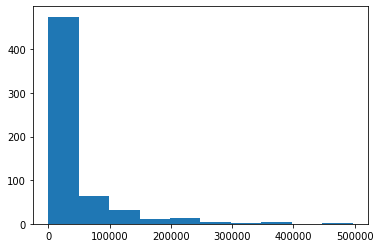

In [25]:
plt.hist(l_stats)
#l_stats

Suggesting patch parameters

In [3]:
patchlevels = 3
#patchlevels = 1

cover = 0.7
#target_element_size_scale = math.sqrt(2.0)
target_element_size_scale = 1.0
pfield=(64,64,64)
#pfield=(64,64,64)
isotropic = True

print("estimating patch parameters")
patch_params = dataset_train.estimate_parameters(depth=patchlevels,cover=cover,pfield=pfield,isotropic=isotropic,target_element_size_scale=target_element_size_scale)
print(patch_params)


estimating patch parameters
target_element_size before adjustment: tensor([1., 1., 1.])
target_element_size after adjustment: tensor([1., 1., 1.])
coarsest patch size: tensor([137.9000, 163.1000, 132.3000]) 
detailed patch size: tensor([64., 64., 64.]) 
s factor: tensor([1.4679, 1.5964, 1.4378]) 
patch size for scale 0 is tensor([64., 64., 64.])
patch size for scale 1 is tensor([ 93.9447, 102.1685,  92.0174])
patch size for scale 2 is tensor([137.9000, 163.1000, 132.3000])
scale facts:
 tensor([[1.0000, 1.4378, 2.0672],
        [1.0000, 1.4378, 2.0672],
        [1.0000, 1.4378, 2.0672]])
{'target_element_size': tensor([1., 1., 1.]), 'scale_facts': tensor([[1.0000, 1.4378, 2.0672],
        [1.0000, 1.4378, 2.0672],
        [1.0000, 1.4378, 2.0672]]), 'depth': 3, 'smallest_img_size_mu': tensor([197., 233., 189.])}


In [4]:
Task = "ATLAS_train_64_rerun"
log_dir = "./logs_atlas_64_rerun/"

new_net = True
torch.cuda.empty_cache()

arc = unet_model_builder
Net_settings = {
            "fin":None,
            "fout":None,
            "depth":5,
            "noskip":[],
            "norm":'BatchNorm',
            "conv_block":"conv_block",
            "dropouts":0.0,
            "skip_type":"3x3",
            "feat_fun":"lambda d:16*(d+1)",
            "skip_feat_fun":"lambda d:16*(d+1) //2",
            "up_feat_fun":"lambda d:16*(d+1) // 2",
            "pfield":None,
            "upsampling":"conv",
            "probabilistic_enc":False,
}


    
pw_layout={
    "verbose":1,
    "dim":dim,
    "fin":n_modalities,
    "labels":n_labels,    
    #"normalize_inputs":"std_mean_separately",
    "normalize_inputs":"std_mean",
    #"normalize_inputs":None,
    "prop_norm":"BatchNorm",
    #"prop_norm":None,
    "pfield":pfield,
    "scales":
    {
        "params":Net_settings,
        "arc":arc,
        "patchlevels":patchlevels,
        "out":16,
    },
}

verbose = True
mynet = deep_patch_work(pw_layout=pw_layout,verbose=verbose)
print("paramters (trainable): {}".format(pw_tools.get_n_parameters(mynet)))

writer = SummaryWriter(log_dir,comment=Task)    
    
if False:
    dataset_train.ready = False
    dataset_trainA.ready = False
    dataset_trainB.ready = False

normalization : std_mean
fin [1, 16]
['enc0', 'dec0', 'down0', 'skip0', 'enc1', 'dec1', 'up1', 'down1', 'skip1', 'enc2', 'dec2', 'up2', 'down2', 'skip2', 'enc3', 'dec3', 'up3', 'down3', 'skip3', 'enc4', 'dec4', 'up4', 'down4', 'skip4', 'enc5', 'up5', 'OUT']
['dec0', 'skip0', 'dec1', 'up1', 'skip1', 'dec2', 'up2', 'skip2', 'dec3', 'up3', 'skip3', 'dec4', 'up4', 'skip4', 'up5', 'OUT']
['dec0', 'dec1', 'up1', 'dec2', 'up2', 'dec3', 'up3', 'dec4', 'up4', 'up5', 'OUT']
['dec0', 'dec1', 'up1', 'dec2', 'up2', 'dec3', 'up3', 'dec4', 'up4', 'OUT']
['dec0', 'dec1', 'up1', 'dec2', 'up2', 'dec3', 'up3', 'up4', 'OUT']
['dec0', 'dec1', 'up1', 'dec2', 'up2', 'dec3', 'up3', 'OUT']
['dec0', 'dec1', 'up1', 'dec2', 'up2', 'up3', 'OUT']
['dec0', 'dec1', 'up1', 'dec2', 'up2', 'OUT']
['dec0', 'dec1', 'up1', 'up2', 'OUT']
['dec0', 'dec1', 'up1', 'OUT']
['dec0', 'up1', 'OUT']
['dec0', 'OUT']
['OUT']
inputs : ['IN0', 'IN1']
IN->enc0->down0->enc1->down1->enc2->down2->enc3->down3->enc4->down4->enc5->skip0->skip1

In [5]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, mode="global"):
        super().__init__()
        self.mode = mode

    def forward(self, inputs, targets, smooth=0.0001):
        
        
        if self.mode == "global":
            inputs = inputs.reshape(-1)
            targets = targets.reshape(-1)
            intersection = (inputs * targets).sum()    
            return 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) 

        if self.mode in ["reduce_mean","reduce_max"]:
            inputs = inputs.reshape([inputs.shape[0],-1])
            targets = targets.reshape([inputs.shape[0],-1])
            
            intersection = (inputs * targets).sum(dim=(1,))    
            score = 1 - (2.*intersection + smooth)/(inputs.sum(dim=(1,)) + targets.sum(dim=(1,)) + smooth)

            if self.mode == "reduce_mean":
                return  score.mean()
            if self.mode == "reduce_max":
                return  score.amax()
            

def activation(tensor,indx=None,not_used=True):
    #we do nothing special here
    return tensor
    

def regloss(prediction, 
                labels,
                patch_imgs,
                writer,
                n_scales,
                activation,
                start_scale=0,
                ):
        
        if writer[1]%100==0:
        #if writer[1]%10==0:
                        clear_output(wait=True)
        loss = 0
        correct = 0
        total = 0
        #bce = nn.BCELoss(reduction="mean")
        bce = nn.BCEWithLogitsLoss(reduction="mean")
        #bce = nn.MSELoss()
        #dice = DiceLoss(mode="reduce_mean")
        #bce_none = nn.BCEWithLogitsLoss(reduction="none")
        sigm = torch.sigmoid
        prefix = "train/"

        for s in range(start_scale,n_scales):
                #the input patches
                inputs = patch_imgs.patchlist[s].tensor[:,None,0,...]
                
                #the ground truth labels 
                gt = labels.patchlist[s].tensor[:,:-1,...]
                #the last label is an indicater for out-of-images voxels
                #1 = in image , 0 = out of image
                valid = labels.patchlist[s].tensor[:,-1,None,...] > 0
                #logits (for BCE, use logits!!)
                pred_logits = prediction[str(s)][:,:1,...]
                #predictions (with sigmoid)
                pred = sigm(pred_logits)
                
                valid_idx = gt.amax(dim=(1,2,3,4))
                valid_p= torch.where((valid_idx>0.5)>0)
                valid_n = torch.where((valid_idx<0.5)>0)

                if True:
                    gt_v = gt#*valid
                    pl = pred_logits#*valid
                    pv = pred#*valid
                    l = bce(pl,gt_v)
                
                if False:
                    gt_v = gt[valid]
                    pl = pred_logits[valid]
                    pv = pred[valid]

                    #here, we only compute the loss for voxels withing the image
                    l = bce(pl,gt_v)
                if False:
                    gt_v = gt*valid
                    pl = pred*valid
                    #here, we only compute the loss for voxels withing the image
                    gt_size = gt_v.reshape([gt_v.shape[0],-1]).sum(dim=(1,))
                    gt_with_labels = gt_size>0                    
                    
                    l = 0
                    if gt_with_labels.sum()>0:
                        l = dice(pl[gt_with_labels,...],gt_v[gt_with_labels,...])
                    
                    pl_bce = pred_logits[valid]
                    gt_v_bce = gt[valid]
                    l += bce(pl_bce,gt_v_bce)
                    
                loss += l
                
                
                if False:
                    print("loss ", l)
                    print("valid ", valid.sum())
                    print(inputs.amin()," ",inputs.amax()," ",inputs.isnan().any())
                    print(gt.amin()," ",gt.amax()," ",gt.isnan().any())
                    print(pred.amin()," ",pred.amax()," ",pred.isnan().any())
                    print(pred_logits.amin()," ",pred_logits.amax()," ",pred_logits.isnan().any())


                # store some info for tensorboard
                # and show some example images
                if writer is not None:
                    if writer[1]%50==0:
                    #if True:
                        if len(valid_n[0])>0 and len(valid_p[0])>0:
                            show_patches = [valid_p[0][0],valid_n[0][0]]
                            print("scale ",s)
                            for pi in show_patches:
                                in_ = inputs[pi,0,...,16].clone()
                                in_ -= in_.amin()
                                in_ /= in_.amax()+0.0001
                                plt.imshow(torch.cat( (
                                    in_,
                                    gt[pi,0,...,16],
                                    pred[pi,0,...,16].detach(),
                                    gt[pi,0,...].amax(dim=2),
                                    pred[pi,0,...].detach().amax(dim=2),
                                    valid[pi,0,...,16],
                                    ),
                                    dim=1).cpu(),vmin=0,vmax=1)
                                plt.axis('off')
                                plt.show()
                    writer[0].add_scalar(prefix+'Loss/train_'+str(s)+"_x", l.item(), writer[1])
                        

        # scale the loss according to the number of scales
        loss /= n_scales
        
        
        if writer is not None:
                writer[0].add_scalar(prefix+'Loss/train_all', loss.item(), writer[1])

        # I forgot for what the second value was.
        return loss,1,None    


    

In [ ]:
if False:
    new_net = False
    mynet = deep_patch_work('models/'+Task+'.tar')
    print("model updated :",time.ctime(os.path.getmtime('models/'+Task+'.tar')))
    writer = SummaryWriter(log_dir,comment=Task)  

scale  0


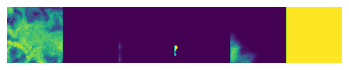

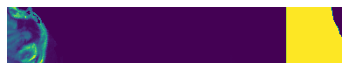

scale  1


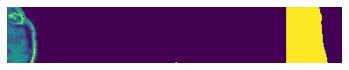

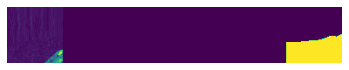

scale  2


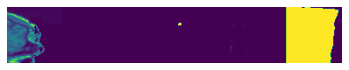

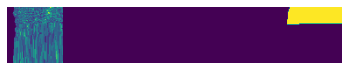

scale  0


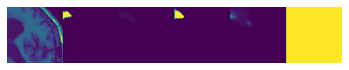

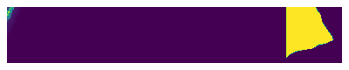

scale  1


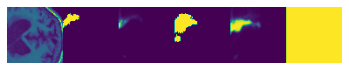

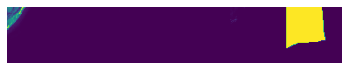

scale  2


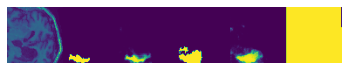

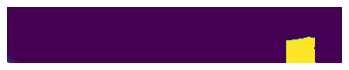

sampling 10 - 10 patches out of 600 datasets 


In [ ]:
#torch.autograd.set_detect_anomaly(True)
torch.autograd.set_detect_anomaly(False)
torch.cuda.empty_cache()

patchbuffersize = 20000

sampling = "pdf_coarse2fine"

train_device = "cuda"
aug_device = "cuda"

batch_size = 25
resample = 10
patchbuffersize = 5000


Testrun = False
Paralell = True

#Testrun = True
Paralell = False

# for untested settings,
# try first a dryrun without GPU
# -> in case everything is ok, better reinit the model first.
if Testrun:
    resample = 1
    batch_size = 10
    patchbuffersize = 10
    aug_device = "cpu"
    train_device = "cpu"


augmentation = { 
            "aug_rot":360,
            "aug_rot_mode":"xyz",
            "aug_scale2":[0.7,1.3],
            "aug_rot_inv_after_scale":True,
            "aug_rot2":25,
            "aug_rot_mode2":"xyz",
            "aug_flipdims":[0],
            "wobble":{"amount":[0.5,0.5,0.5,0.5],"gridsize":[0.004,0.01,0.02,0.1],"prob":[0.75,1]},
}

#augmentation = {}


intensity_augmentation = None
if False:
    intensity_augmentation = {"aug_fun":pw_tools.aug_patchbatch,
                             "aug_params":
                             {
                                 #"randn_rel":{"rate":0.5,"range":[0.05,0.1]},
                                 #"gamma":{"rate":0.5,"range":[0.9,1.1]},
                                 "contrast":{"rate":1,"range":[0.8,1.2]},
                             }}
prior = None

# weights for sampling ratio forgrand/background 
weights = {'bg':1,'classes':[1],"sample_from_class_indx":[-1]}
pw_loss = {"loss":regloss,"params":{"activation":activation,}}


if Paralell:
    def resample_patches(pw_data,network):
        settings = {
                     "sampling":sampling,
                     "target_element_size":patch_params["target_element_size"],
                     "patchbuffersize":patchbuffersize,
                     "scale_facts":patch_params["scale_facts"],
                     "augmentation":augmentation,
                     "progress_callback":None,
                     "sample_from_label":1,
                     "weights":weights,
                     "snap":"valid",
                     "sampler_debug_scales":0,
                     "patch_update_rate":1,
                     "pin_mem":False,
                     }
        start_t = time.time()
        pw_data.resample(                 
                     pfield=network.pw_layout["pfield"],**settings)  
        end_t = time.time()
        print("total time : {}".format(end_t - start_t))
        dps = patchbuffersize/(end_t - start_t)
        print("datasets per second : {}".format(dps))

    for a in range(1 if Testrun else 10000000):
        dataset_trainA, dataset_trainB = dataset_trainB, dataset_trainA

        class fun_background(Thread):

            def __init__(self):
                Thread.__init__(self)

            def run(self):
                print("background function starts")
                resample_patches(dataset_trainB,mynet)
                #return_dict["dataset_patches_i"] = dataset_trainB.img_patches
                #return_dict["dataset_patches_l"] = dataset_trainB.labels_patches
                print("background function stops")



        p1 = fun_background()           
        p1.start()

        for b in range(resample):
            clear_output(wait=True)


            print("training function starts")
            if not dataset_trainA.ready:
                print("training function needs to resample first")
                resample_patches(dataset_trainA,mynet)


            mynet.train_epoch(
                            augmentation = augmentation,
                      intensity_augmentation=intensity_augmentation,
                      sampling = sampling,
                      aug_device = aug_device,
                      patchbuffersize = patchbuffersize,
                      weights = weights,
                      snap = "valid",
                      scale_facts = patch_params["scale_facts"],
                      sampler_debug_scales = 0,
                      target_element_size = patch_params["target_element_size"],
                      batch_size = batch_size,
                      resample = resample,
                      train_device = train_device,
                      optimizer = {"optim":optim.AdamW,"params":{"lr":0.001, "eps":1e-07}},
                      scheduler = {"scheduler":ExponentialLR,"params":{"gamma":0.995}},  
                      dataset_train = dataset_trainA,
                      writer = writer,
                      clear = new_net,
                      pw_loss = pw_loss,
                      do_resampling=False)
            new_net = False
            print("training function stops")

        print("joining threads")

        p1.join()

        print("done pw_parallel")
        print("updating background buffer values")

        assert(dataset_trainA.ready)
        assert(dataset_trainB.ready)
        if not Testrun:
            mynet.model_save('models/'+Task+'.tar')
else:



    for a in range(1 if Testrun else 10000000):
        mynet.train_epoch(
                  augmentation = augmentation,
                  intensity_augmentation=intensity_augmentation,
                  sampling = "pdf_coarse2fine",
                  aug_device = aug_device,
                  patchbuffersize = patchbuffersize,
                  weights = weights,
                  snap = "valid",
                  scale_facts = patch_params["scale_facts"],
                  sampler_debug_scales = 0,
                  target_element_size = patch_params["target_element_size"],
                  batch_size = batch_size,
                  resample = resample,
                  train_device = train_device,
                  optimizer = {"optim":optim.AdamW,"params":{"lr":0.001, "eps":1e-07}},
                  #optimizer = {"optim":optim.Adam,"params":{}},
                  scheduler = {"scheduler":ExponentialLR,"params":{"gamma":0.995}},  
                  dataset_train = dataset_train,
                  writer = writer,
                  clear = new_net,
                  pw_loss = pw_loss,
                  do_resampling=True)

        # we set this to false so that we can restart anytime without resetting patchwork training params    
        new_net = False

        if not Testrun:
            mynet.model_save('models/'+Task+'.tar')
    

In [ ]:
!ls

In [37]:
#new_net
dataset_trainA.interrupt_me = True
dataset_trainB.interrupt_me = True


done: total time : 1084.3465530872345, datasets per second : 18.444287892148648
done
total time : 1084.3482522964478
datasets per second : 18.44425898934565
background function stops


In [5]:
from pw.networks import DummyNet_builder

Net_settings = {
            "fin":None,
            "fout":None,
            }
arc = DummyNet_builder
pw_layout={
    "dim":dim,
    "fin":n_modalities,
    "labels":n_labels,    
    "normalize_inputs":None,#"std_mean" if MRI else None,
    "prop_norm":None,
    "pfield":pfield,
    "scales":
    {
        "params":Net_settings,
        "arc":arc,
        "patchlevels":patchlevels,
        "out":1,
    },
   }
    
mynet2 = deep_patch_work(pw_layout=pw_layout)

normalization : None


sampling 10 patches per 1 datasets out of 1 datasets in total ...
from the last image, we sample all 10 reamining patches
done: total time : 1.3187098503112793, datasets per second : 7.583169260197394
done


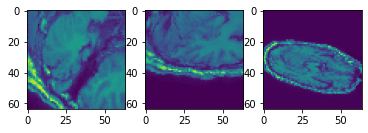

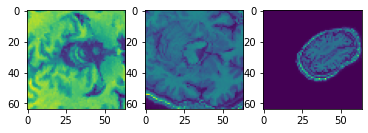

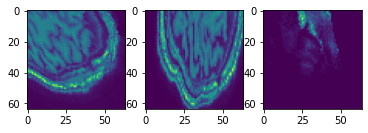

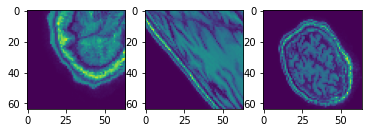

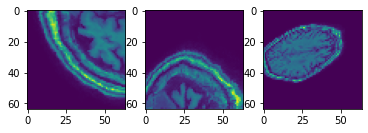

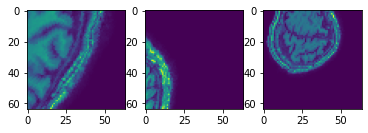

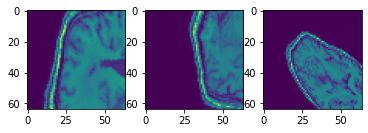

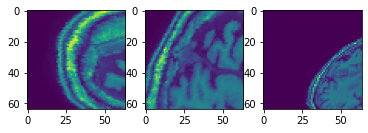

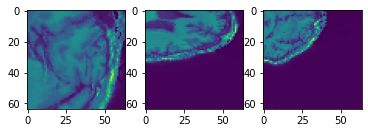

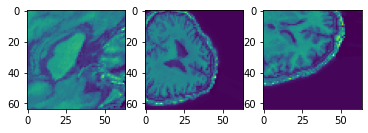

In [18]:
sampling = "pdf_coarse2fine"
aug_device = "cpu"
patchbuffersize = 10
sample_from_label = 1
sampler_debug_scales = 0
weights = {'bg':1,'classes':[1],"sample_from_class_indx":[-1]}

pfield_ = pfield
#pfield_ = (128,128,128)

prop = False

augmentation = {    
            "aug_rot":360,
            "aug_rot_mode":"xyz",
            #"aug_scale":[0.8,1.2],
            "aug_rot_keep_mat":True,
            "aug_rot_inv_after_scale":True,
            "aug_rot2":30,
            "aug_rot_mode2":"xyz",
            "aug_scale2":[0.8,1.2],
            #"wobble":{"amount":[0.5,0.5,0.5,0.5],"gridsize":[0.004,0.01,0.02,0.1],"prob":[0.75,1]},
            }

augmentation = { 
            "aug_rot":360,
            "aug_rot_mode":"xyz",
            "aug_scale2":[0.5,2.0],
            "aug_rot_inv_after_scale":True,
            "aug_rot2":30,
            "aug_rot_mode2":"xy",
            "aug_flipdims":[0],
            "wobble":{"amount":[0.5,0.5,0.5,0.5],"gridsize":[0.004,0.01,0.02,0.1],"prob":[0.75,1]},
}
dataset_train.resample(
                 pfield = pfield_,
                 aug_device=aug_device,
                 sampling=sampling,
                 target_element_size= patch_params["target_element_size"],
                 patchbuffersize=patchbuffersize,
                 scale_facts = patch_params["scale_facts"],
                 augmentation=augmentation,
                 sample_from_label=sample_from_label,
                 weights=weights,
                 sampler_debug_scales=sampler_debug_scales)  


intensity_augmentation = {}

mpl.rcParams['figure.dpi']  = dpi_default 
if prop:
    with torch.no_grad():
        mynet2.eval()
        pred1 = mynet2(dataset_train.img_patches)

        for b in range(patchbuffersize):
            for sc in range(patchlevels):
                img = pred1["0"][b,sc,...]
                plt.subplot(1, patchlevels, sc+1)
                plt.imshow(img[:,:,0])
            plt.pause(0.0001)
    
if not prop:
    img_patchlist =  dataset_train.img_patches.patchlist
    #_patchlist =  dataset_train.img_patches.patchlist
    
    pw_tools.aug_patchbatch(img_patchlist,3,intensity_augmentation)
    
    if True:
        for b in range(patchbuffersize):
            for sc in range(patchlevels):
                img = img_patchlist[sc].tensor[b,...]
                assert(not img.isnan().any())
                #print("{} {}".format(img.amin(),img.amax()))
                plt.subplot(1, patchlevels, sc+1)
                #plt.imshow(img[0,...,0])
                #plt.imshow(img[0,...,pfield_[1]//2,:])
                plt.imshow(img[0,...,pfield_[1]//2])
                #plt.imshow(img[0,pfield_[0]//2,...])
            plt.pause(0.0001)

mpl.rcParams['figure.dpi']  = dpi_default   

Applying model